In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import spikeinterface.full as si
from pathlib import Path
import shutil

import numpy as np

import matplotlib.pyplot as plt

In [5]:
base_folder = Path("/home/samuel/DataSpikeSorting")


In [6]:
job_kwargs = dict(n_jobs=-1, progress_bar=True, chunk_duration="1s")

In [1]:
recording, gt_sorting = si.generate_ground_truth_recording(
    durations=[300.0, ],
    sampling_frequency=30000.0,
    num_channels=4,
    num_units=5,
    generate_sorting_kwargs=dict(firing_rates=3.0, refractory_period_ms=4.0),
    noise_kwargs=dict(noise_level=5.0, strategy="tile_pregenerated"),
    seed=2205,
)


NameError: name 'si' is not defined

In [2]:
sorter_folder = base_folder / "dev_simple_sorter"
if sorter_folder.exists():
    shutil.rmtree(sorter_folder)

sorter_params = dict(
    apply_preprocessing=True,
    # apply_preprocessing=False,
    waveforms=dict(ms_before=1.0, ms_after=1.8),
    filtering=dict(freq_min=300, freq_max=8000.0),
    detection=dict(peak_sign="neg", detect_threshold=5., exclude_sweep_ms=0.4, radius_um=100),
    features=dict(n_components=3),
    clustering=dict(method="hdbscan"),
    # clustering=dict(method="kmeans", n_clusters=3),
    # clustering=dict(method="gaussian_mixture", n_components=5),
    # clustering=dict(method="mean_shift", bin_seeding=True),
    # clustering=dict(method="affinity_propagation"),
    job_kwargs=dict(n_jobs=-1),
)
sorting = si.run_sorter("simple", recording, output_folder=sorter_folder, verbose=True, **sorter_params)
print(sorting)


NameError: name 'base_folder' is not defined

In [9]:
features = np.load(sorter_folder / "sorter_output/features/features_tsvd.npy")

features_flat = features.reshape(features.shape[0], -1)

peak_labels = np.load(sorter_folder / "sorter_output/features/peak_labels.npy")

print(features_flat.shape, features.shape, peak_labels.shape,features.dtype)


(8437, 24) (8437, 3, 8) (8437,) float32


/home/samuel/.virtualenvs/py3.10/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


<Axes: >

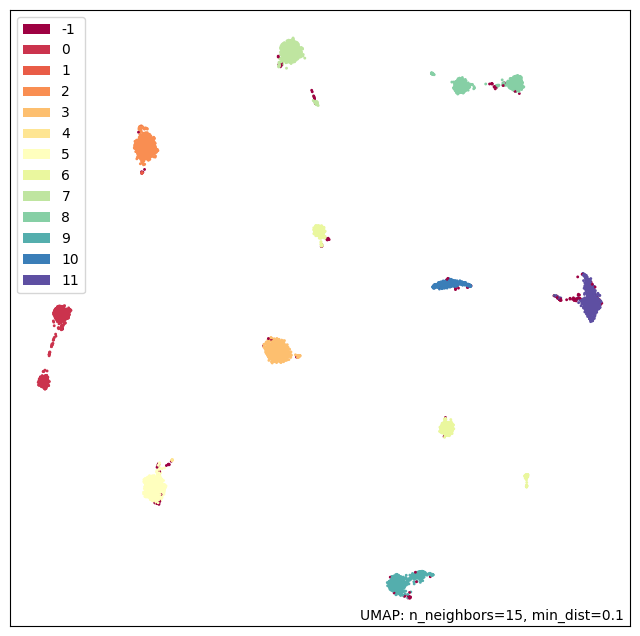

In [10]:
import umap
import umap.plot

mapper = umap.UMAP().fit(features_flat)
print(mapper)
umap.plot.points(mapper, labels=peak_labels)



In [11]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=False)
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
analyzer.compute("quality_metrics", metric_names=["snr"])
analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/12 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/12 [00:00<?, ?it/s]

SortingAnalyzer: 8 channels - 12 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [12]:
%gui qt
si.plot_sorting_summary(analyzer, backend="spikeinterface_gui")


In [11]:
gt_analyzer = si.create_sorting_analyzer(gt_sorting, recording, sparse=False)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"], **job_kwargs)
gt_analyzer.compute(["spike_amplitudes", "unit_locations", "principal_components", "correlograms", "template_similarity"], **job_kwargs)
gt_analyzer.compute("quality_metrics", metric_names=["snr"])
gt_analyzer

compute_waveforms:   0%|          | 0/300 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/5 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/5 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 5 units - 1 segments - memory - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, unit_locations, principal_components, correlograms, template_similarity, quality_metrics

In [12]:
si.plot_sorting_summary(gt_analyzer, backend="spikeinterface_gui")